In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import seaborn as sns
from scipy.stats import pearsonr
import optuna

import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
def gen_lagged_data(metadata, data, last_date, lag):
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0]
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

def flatten_data(data, target_variable, n_lags):
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]
    orig_index = flattened_data.index
    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = tmp.date + pd.DateOffset(months=i)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")

    return flattened_data

def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

# Data set up

In [3]:
data = pd.read_excel("C:/Users/lysov/Desktop/4 курс/ВКР/New Data/data_tf.xlsx", decimal = ',', parse_dates=["date"])
metadata = pd.read_csv("C:/Users/lysov/Desktop/4 курс/ВКР/New Data/meta_data.csv", delimiter = ";")
data_num = data.loc[:, data.columns != 'date']

target_variable = "gdp"

lags = list(range(-2, 3))

train_start_date = "2011-01-01"
train_end_date = "2018-12-01"
test_start_date = "2019-03-01"
test_end_date = "2023-09-01"

test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

In [103]:
# names = ['date', 'gdp',
#          # sectors
#          'agri', 'mining', 'manufacturing', 'egpiv', 'construction', 'trade', 'transport', 'finance', 'real_estate', 'others', 'taxes',
#          # PMI
#          'PMI_Mnf', 'PMI_Serv', 'PMI_Comp',
#          # IBC total
#          'IBC_total',  'IBC_total_fact', 'IBC_total_3m', 'IBC_total_output', 'IBC_total_output_3m', 'IBC_total_demand',
#          'IBC_total_demand_3m', 'IBC_total_price', 'IBC_total_price_3m','IBC_total_costs', 'IBC_total_credit',
#          # IBC ip
#          'IBC_ip', 'IBC_ip_fact', 'IBC_ip_3m', 'IBC_ip_output', 'IBC_ip_output_3m', 'IBC_ip_demand',
#          'IBC_ip_demand_3m', 'IBC_ip_price', 'IBC_ip_price_3m', 'IBC_ip_costs', 'IBC_ip_credit', 
#          # IBC mining
#          'IBC_mining', 'IBC_mining_fact', 'IBC_mining_3m', 'IBC_mining_output', 'IBC_mining_output_3m', 'IBC_mining_demand',
#          'IBC_mining_demand_3m', 'IBC_mining_price', 'IBC_mining_price_3m', 'IBC_mining_costs', 'IBC_mining_credit',
#          # IBC manufacturing
#          'IBC_mnf', 'IBC_mnf_fact', 'IBC_mnf_3m', 'IBC_mnf_output', 'IBC_mnf_output_3m', 'IBC_mnf_demand',
#          'IBC_mnf_demand_3m', 'IBC_mnf_price', 'IBC_mnf_price_3m', 'IBC_mnf_costs', 'IBC_mnf_credit',
#          # IBC constr
#          'IBC_constr', 'IBC_constr_fact', 'IBC_constr_3m', 'IBC_constr_output','IBC_constr_output_3m', 'IBC_constr_demand',
#          'IBC_constr_demand_3m', 'IBC_constr_price', 'IBC_constr_price_3m', 'IBC_constr_costs', 'IBC_constr_credit',
#          # IBC trade
#          'IBC_trade', 'IBC_trade_fact', 'IBC_trade_3m', 'IBC_trade_output', 'IBC_trade_output_3m', 'IBC_trade_demand',
#          'IBC_trade_demand_3m', 'IBC_trade_price', 'IBC_trade_price_3m', 'IBC_trade_costs', 'IBC_trade_credit',
#          # IBC transp
#          'IBC_transp', 'IBC_transp_fact', 'IBC_transp_3m', 'IBC_transp_output', 'IBC_transp_output_3m', 'IBC_transp_demand', 
#          'IBC_transp_demand_3m', 'IBC_transp_price', 'IBC_transp_price_3m', 'IBC_transp_costs', 'IBC_transp_credit',
#          # IBC serv
#          'IBC_serv', 'IBC_serv_fact', 'IBC_serv_3m', 'IBC_serv_output', 'IBC_serv_output_3m', 'IBC_serv_demand',
#          'IBC_serv_demand_3m', 'IBC_serv_price', 'IBC_serv_price_3m', 'IBC_serv_costs', 'IBC_serv_credit',
#          # hse + rspp
#          'hse', 'rspp1', 'rspp2', 'rspp3', 'rspp4', 'rspp5', 'rspp6', 'rspp7',
#          # ipu rosstat
#          'ipu_constr1', 'ipu_constr2', 'ipu_constr3',
#         #  # ip
#          'ip', 'ip_raw',  'ip_coal', 'ip_oil_products',
#          'ip_chemicals', 'ip_man', 'ip_metals', 'ip_constr', 'ip_cars', 'ip_food', 'ip_nonfood', 'ip_el',
#          # rail + cargo
#          'rail', 'cargo_rail', 'cargo_auto', 'cargo_sea', 'cargo_pipe',
#          # constr
#          'constr_vol', 'constr_prices',
#          # serv
#          'retail_prod', 'retail_neprod', 'pserv', 'obschepit',
#          # labor
#          'dispinc', 'eap', 'unemp', 'nwage',
#          # cars
#          'cars', 'trucks',
#          # financial
#          'miacr', 'rtc', 'moex', 'reer', 'rvi', 'm0', 'm2x', 'ofz1', 'ofz3', 'ofz5', 'ofz10',
#          # dep/cred rates 
#          'dep_hh_rate', 'dep_nfo_rate', 'cred_hh_rate', 'cred_nfo_rate',
#          # ust
#          't2', 't10',
#          # external conditions
#          'ism_man', 'ism_serv', 'us_cpi', 'eu_cpi', 'cpi', 'cpi_prod', 'cpi_neprod', 'cpi_serv', 'ppi',
#          'brent', 'urals', 'aluminium', 'gold', 'gas']

# data = data.loc[:, names]
# # test dataset
# test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

In [4]:
corr = data_num.corr(method='pearson')

# remove highly correlated predictors
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data_num.columns[columns].insert(0, 'date')

data_selected = data.loc[:, selected_columns]
test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)

In [5]:
def r_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return p


In [6]:
data_num = data.loc[:, data.columns != 'date']
pvals = r_pvalues(data_num)

In [7]:
selected_columns = data_num.loc[:, pvals[target_variable] < 0.1].columns
selected_columns = selected_columns.insert(0, 'date')
data_selected = data.loc[:, selected_columns]
test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)

In [15]:
def nowcast_ridge(model_params, target_variable, dates, actuals):
    
    selected_columns = data_num.loc[:, pvals[target_variable] < model_params['pval']].columns
    selected_columns = selected_columns.insert(0, 'date')
    data_selected = data.loc[:, selected_columns]
    test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
    test_t = test_selected

    pred_dict = {k: [] for k in lags}
    try:
        for date in dates:
            train = test_t.loc[test_t.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:]
            transformed_train = mean_fill_dataset(train, train)
            transformed_train = flatten_data(transformed_train, target_variable, model_params['flat'])
            transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)
            
            model = Ridge(alpha = model_params['alpha'])
            x = transformed_train.drop(["date", target_variable], axis=1)
            y = transformed_train[target_variable]
            model.fit(x, y)
            
            for lag in lags:
                tmp_data = gen_lagged_data(metadata, test_t, date, lag)

                tmp_data = mean_fill_dataset(train, tmp_data)
                tmp_data = flatten_data(tmp_data, target_variable, model_params['flat'])
                x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
                
                pred = model.predict(x)[0]
                pred_dict[lag].append(pred)
                  
        curr_MAE = np.mean(np.abs((np.array(actuals) - np.array(pred_dict[2]))))
    except: curr_MAE = 1000

    return curr_MAE

In [16]:
def objective(trial):
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )
    
    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    pval = trial.suggest_loguniform('pval', 1e-5, 1)
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e5)
    flat = trial.suggest_int('flat', 2, 7, step=1)

    model_params = {'pval': pval, 'alpha': alpha, "flat": flat}
    
    return nowcast_ridge(model_params, target_variable=target_variable, dates=dates, actuals=actuals)
    


In [17]:
def evaluate_ridge(data, model_params, target_variable, plot, save):
    target_variable = target_variable
    alpha = model_params['alpha']
    pval = model_params['pval']
    flat = model_params['flat']
    
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    selected_columns = data_num.loc[:, pvals[target_variable] < pval].columns
    selected_columns = selected_columns.insert(0, 'date')
    data_selected = data.loc[:, selected_columns]
    test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
    test_t = test_selected
    
    pred_dict = {k: [] for k in lags}
    for date in dates:
        train = test_t.loc[test_t.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:]
        transformed_train = mean_fill_dataset(train, train)
        transformed_train = flatten_data(transformed_train, target_variable, flat)
        transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)
        
        model = Ridge(alpha = alpha)
        x = transformed_train.drop(["date", target_variable], axis=1)
        y = transformed_train[target_variable]
        model.fit(x, y)
        
        for lag in lags:
            tmp_data = gen_lagged_data(metadata, test_t, date, lag)

            tmp_data = mean_fill_dataset(train, tmp_data)
            tmp_data = flatten_data(tmp_data, target_variable, flat)
            x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
            
            pred = model.predict(x)[0]
            pred_dict[lag].append(pred)
    
    performance = pd.DataFrame(columns=["Vintage", "RMSE", "MAE"])
    for lag in lags:
        tmp = pd.DataFrame({
            "Vintage":lag,
            "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2)),
            "MAE":np.mean(np.abs((np.array(actuals) - np.array(pred_dict[lag]))))
        }, index=[0])
        performance = pd.concat([performance, tmp]).reset_index(drop=True)
    
    print(performance.round(4))

    if plot == 1:
        predictions_elastic = pd.DataFrame({
            "actuals":actuals, 
            "two_back":pred_dict[-2], 
            "one_back":pred_dict[-1], 
            "zero_back":pred_dict[0],
            "one_ahead":pred_dict[1],
            "two_ahead":pred_dict[2]}
        )
        predictions_elastic.plot()

    if save == 1:
        predictions_elastic.to_excel(f"predictions_{target_variable}_ridge.xlsx")
        

In [18]:
target_variable = 'gdp'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
gdp_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-28 12:10:55,217] A new study created in memory with name: no-name-2f220025-2b4c-4984-8d6f-8390fff7775b
[I 2024-04-28 12:10:58,497] Trial 0 finished with value: 1.1479238677004395 and parameters: {'pval': 0.001663477111599743, 'alpha': 53.60402678141931, 'flat': 6}. Best is trial 0 with value: 1.1479238677004395.
[I 2024-04-28 12:11:00,134] Trial 1 finished with value: 1.6872112723581771 and parameters: {'pval': 4.029066940496639e-05, 'alpha': 0.6426454576299119, 'flat': 2}. Best is trial 0 with value: 1.1479238677004395.
[I 2024-04-28 12:11:02,790] Trial 2 finished with value: 1.4297091292100872 and parameters: {'pval': 0.00017538339064666366, 'alpha': 721.2935775952203, 'flat': 5}. Best is trial 0 with value: 1.1479238677004395.
[I 2024-04-28 12:11:05,579] Trial 3 finished with value: 2.041329971798545 and parameters: {'pval': 0.0010055480265472928, 'alpha': 0.015192259900855055, 'flat': 5}. Best is trial 0 with value: 1.1479238677004395.
[I 2024-04-28 12:11:07,847] Trial 4

Best MAE=0.9478312046056235, best parameters:{'pval': 0.01878611673755212, 'alpha': 0.0010088072579333325, 'flat': 2}


  Vintage    RMSE     MAE
0      -2  2.8427  1.7145
1      -1  2.6636  1.5922
2       0  2.5697  1.5628
3       1  1.6939  1.0695
4       2  1.5199  0.9478


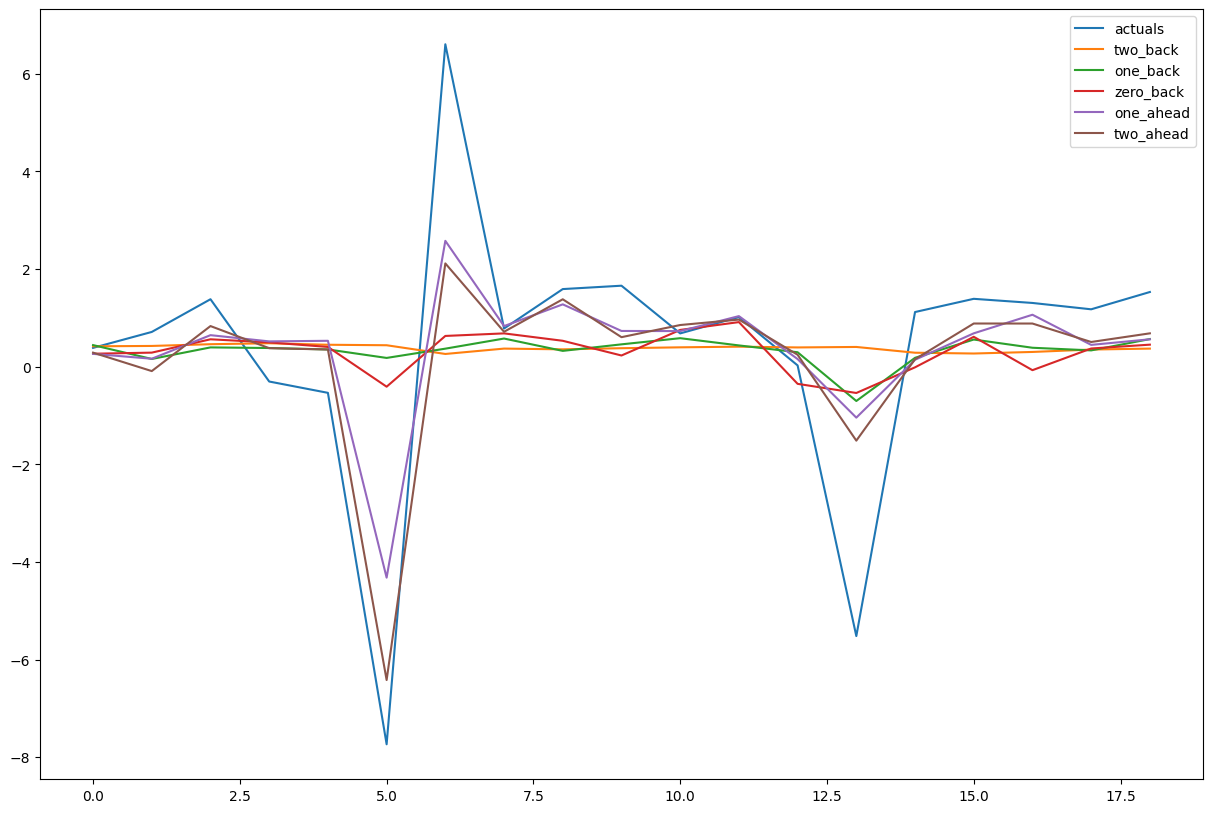

In [22]:
evaluate_ridge(data = data, target_variable='gdp', model_params=gdp_opt_new, plot=1, save=1)

In [23]:
target_variable = 'agri'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
agri_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-28 12:29:02,959] A new study created in memory with name: no-name-9da496ff-c60b-4da4-acf6-4c2b69c00ec7
[I 2024-04-28 12:29:02,997] Trial 0 finished with value: 1000.0 and parameters: {'pval': 0.0015596039098632582, 'alpha': 41241.895391109865, 'flat': 6}. Best is trial 0 with value: 1000.0.
[I 2024-04-28 12:29:03,018] Trial 1 finished with value: 1000.0 and parameters: {'pval': 2.589149850003325e-05, 'alpha': 0.02284713190657882, 'flat': 4}. Best is trial 0 with value: 1000.0.
[I 2024-04-28 12:29:05,371] Trial 2 finished with value: 0.3134110120613244 and parameters: {'pval': 0.14018052633760336, 'alpha': 34509.25366709344, 'flat': 2}. Best is trial 2 with value: 0.3134110120613244.
[I 2024-04-28 12:29:10,061] Trial 3 finished with value: 0.6388102520653997 and parameters: {'pval': 0.2097566751079916, 'alpha': 24.966556411759242, 'flat': 7}. Best is trial 2 with value: 0.3134110120613244.
[I 2024-04-28 12:29:10,095] Trial 4 finished with value: 1000.0 and parameters: {'pval'

Best MAE=0.26879877151104997, best parameters:{'pval': 0.24812552226080498, 'alpha': 6940.760767466006, 'flat': 2}


  Vintage    RMSE     MAE
0      -2  0.4320  0.3195
1      -1  0.4342  0.3182
2       0  0.4353  0.3152
3       1  0.4338  0.3100
4       2  0.4014  0.2688


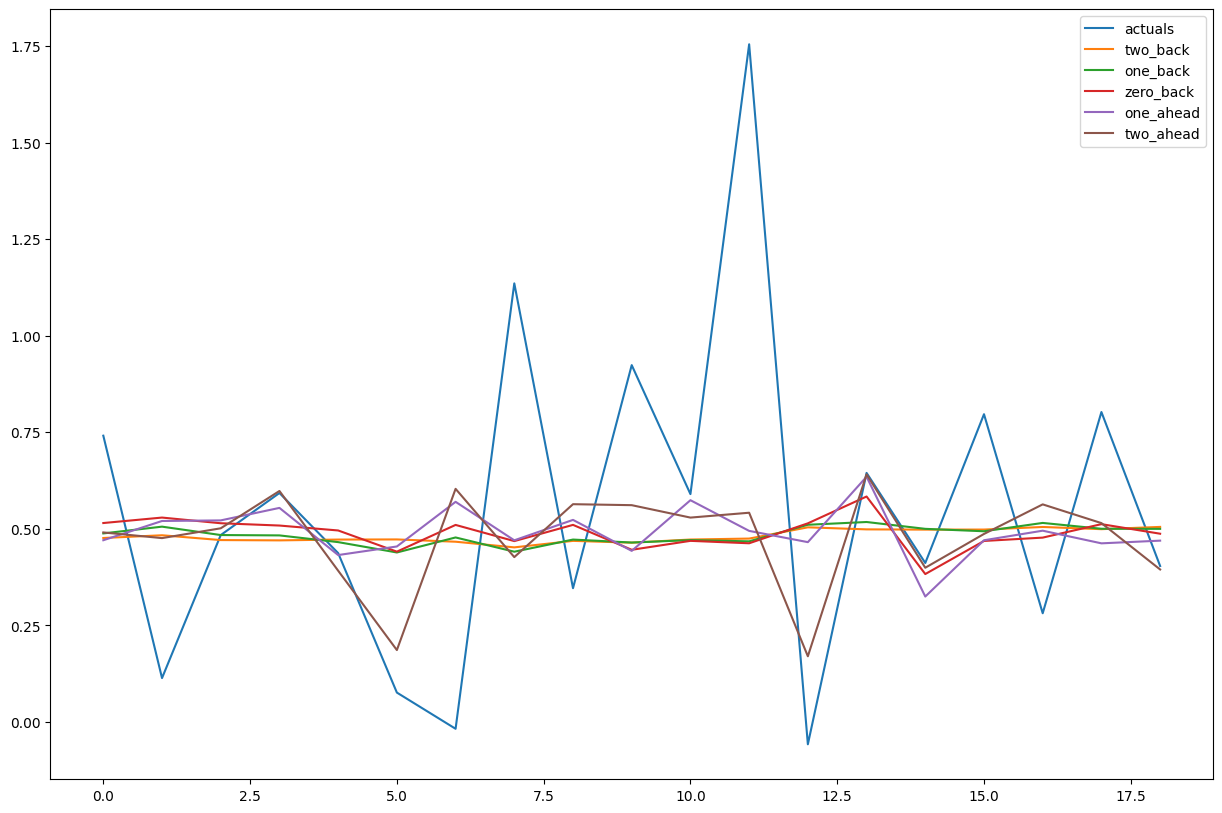

In [31]:
evaluate_ridge(data = data, target_variable='agri', model_params=agri_opt_new, plot=1, save=1)

In [25]:
target_variable = 'mining'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
mining_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-28 12:44:07,086] A new study created in memory with name: no-name-22457a3b-2812-4495-96ca-67ef8e0bb700
[I 2024-04-28 12:44:09,941] Trial 0 finished with value: 5.463049067892756 and parameters: {'pval': 1.3545044491705086e-05, 'alpha': 0.5449887341234038, 'flat': 6}. Best is trial 0 with value: 5.463049067892756.
[I 2024-04-28 12:44:16,483] Trial 1 finished with value: 3.163238099970326 and parameters: {'pval': 0.23057740854182504, 'alpha': 73.29864364837499, 'flat': 2}. Best is trial 1 with value: 3.163238099970326.
[I 2024-04-28 12:44:21,221] Trial 2 finished with value: 3.2488752349785157 and parameters: {'pval': 0.020633102083846225, 'alpha': 0.004524272368294809, 'flat': 6}. Best is trial 1 with value: 3.163238099970326.
[I 2024-04-28 12:44:23,716] Trial 3 finished with value: 2.01917414619989 and parameters: {'pval': 6.574572702367497e-05, 'alpha': 629.758177988927, 'flat': 5}. Best is trial 3 with value: 2.01917414619989.
[I 2024-04-28 12:44:29,363] Trial 4 finished w

Best MAE=1.7238635969275393, best parameters:{'pval': 3.017216118295521e-05, 'alpha': 75.03849228636348, 'flat': 6}


  Vintage    RMSE     MAE
0      -2  3.1988  1.9213
1      -1  3.1900  1.8571
2       0  3.1142  1.7836
3       1  2.6631  1.8143
4       2  2.7045  1.7239


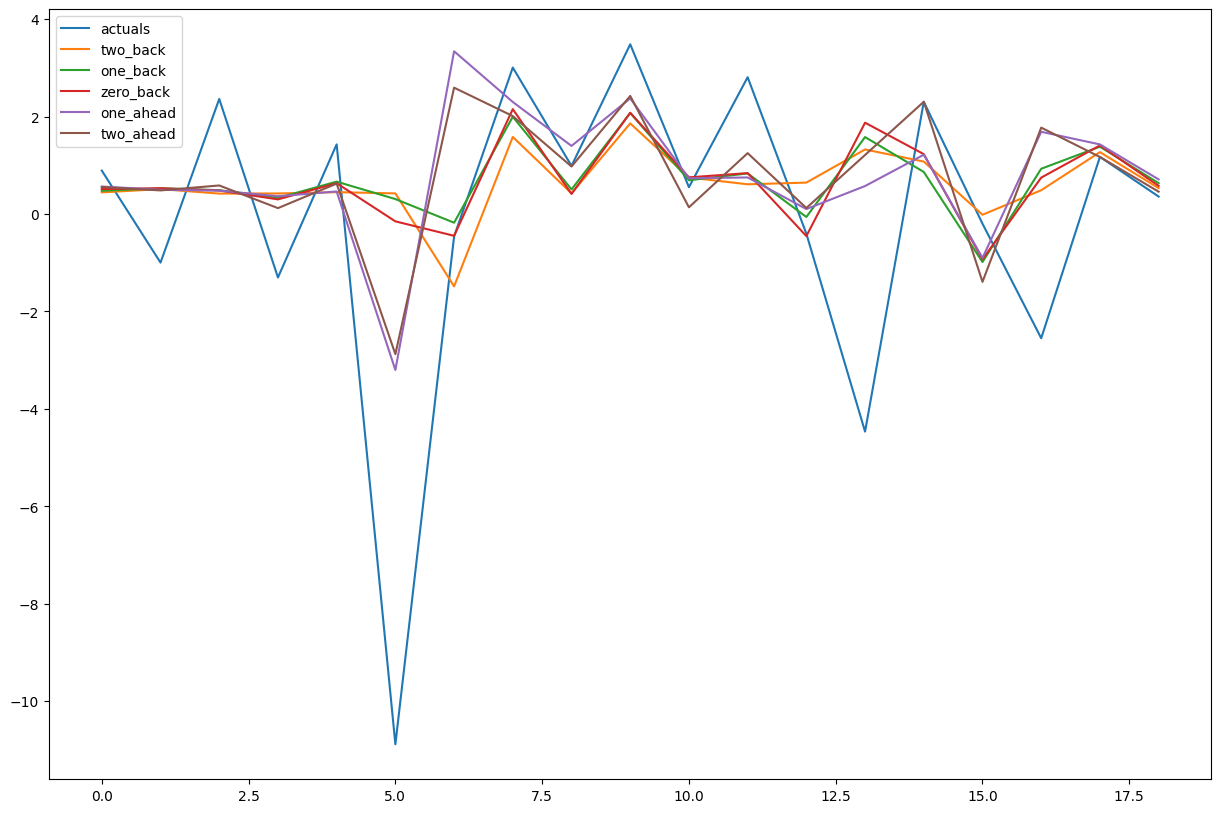

In [30]:
evaluate_ridge(data = data, target_variable='mining', model_params=mining_opt_new, plot=1, save=1)

In [27]:
target_variable = 'manufacturing'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
manufacturing_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-28 12:58:29,736] A new study created in memory with name: no-name-e3d6890c-a4e5-4e05-8ac7-889099e74580
[I 2024-04-28 12:58:31,531] Trial 0 finished with value: 2.3702614283349313 and parameters: {'pval': 0.0011515569172616022, 'alpha': 531.1713896562334, 'flat': 3}. Best is trial 0 with value: 2.3702614283349313.
[I 2024-04-28 12:58:33,023] Trial 1 finished with value: 2.3331394262221163 and parameters: {'pval': 0.002302069671065975, 'alpha': 710.2586123581748, 'flat': 2}. Best is trial 1 with value: 2.3331394262221163.
[I 2024-04-28 12:58:35,052] Trial 2 finished with value: 2.359682431270361 and parameters: {'pval': 3.586135311938535e-05, 'alpha': 329.20739718457304, 'flat': 5}. Best is trial 1 with value: 2.3331394262221163.
[I 2024-04-28 12:58:36,450] Trial 3 finished with value: 2.3331394262221163 and parameters: {'pval': 0.00011407585677199239, 'alpha': 0.01780327298853944, 'flat': 2}. Best is trial 1 with value: 2.3331394262221163.
[I 2024-04-28 12:58:38,732] Trial 4 

Best MAE=1.2429041097637337, best parameters:{'pval': 0.36059943885567464, 'alpha': 363.09433694291084, 'flat': 3}


  Vintage    RMSE     MAE
0      -2  2.9187  2.2043
1      -1  2.5687  1.8718
2       0  1.8021  1.4668
3       1  1.5446  1.2247
4       2  1.6022  1.2429


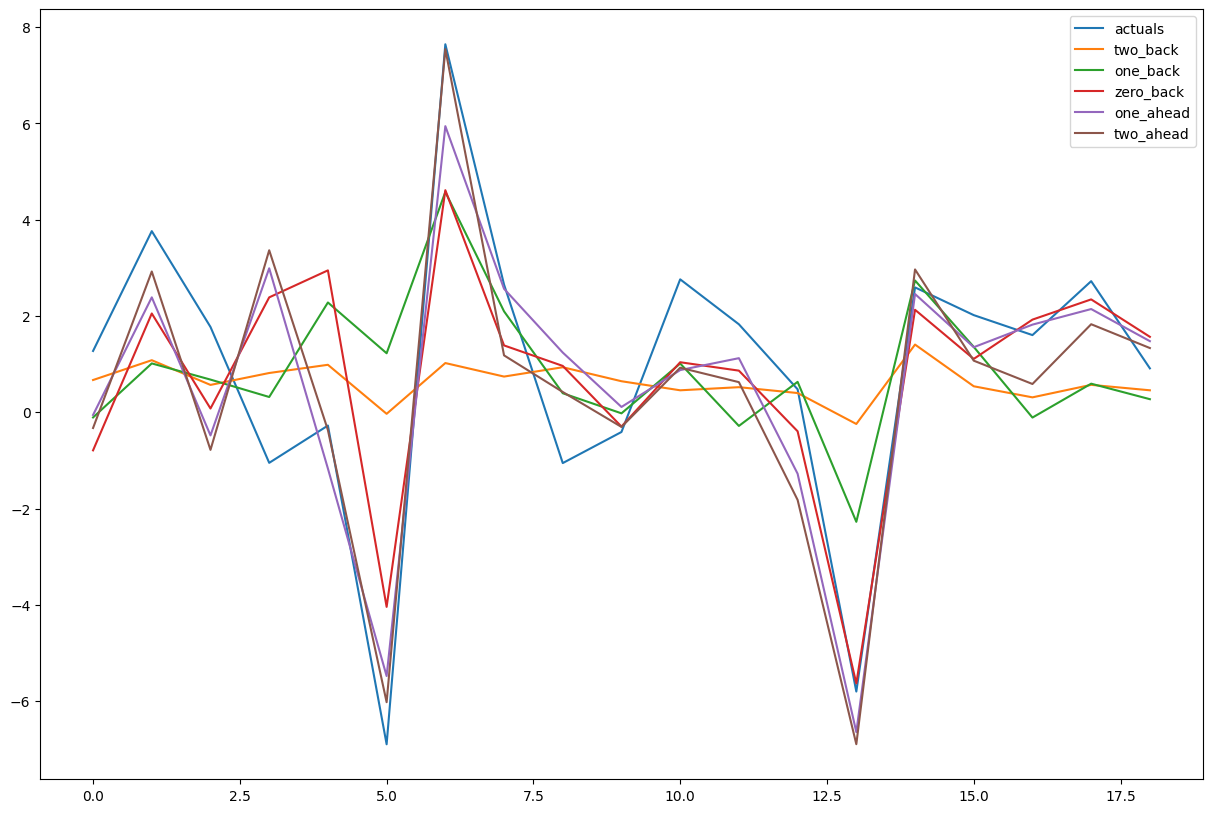

In [29]:
evaluate_ridge(data = data, target_variable='manufacturing', model_params=manufacturing_opt_new, plot=1, save=1)

In [32]:
target_variable = 'egpiv'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
egpiv_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-28 15:22:06,755] A new study created in memory with name: no-name-91dd22ba-858e-4028-8676-b9df2d4caf3f
[I 2024-04-28 15:22:16,790] Trial 0 finished with value: 1.7351309924762428 and parameters: {'pval': 0.4381306072100264, 'alpha': 0.6705488626018996, 'flat': 6}. Best is trial 0 with value: 1.7351309924762428.
[I 2024-04-28 15:22:32,607] Trial 1 finished with value: 1.2454349382319774 and parameters: {'pval': 0.792352599790159, 'alpha': 21.196179380181043, 'flat': 6}. Best is trial 1 with value: 1.2454349382319774.
[I 2024-04-28 15:22:35,995] Trial 2 finished with value: 0.9974163242860319 and parameters: {'pval': 0.0052714484288766275, 'alpha': 9506.76100910957, 'flat': 7}. Best is trial 2 with value: 0.9974163242860319.
[I 2024-04-28 15:22:37,440] Trial 3 finished with value: 1.0215879090978846 and parameters: {'pval': 0.0009135667421871574, 'alpha': 11.798006868602306, 'flat': 2}. Best is trial 2 with value: 0.9974163242860319.
[I 2024-04-28 15:22:37,480] Trial 4 finishe

Best MAE=0.7274611421780274, best parameters:{'pval': 0.1435998359878273, 'alpha': 3319.55468957432, 'flat': 7}


In [33]:
optuna.visualization.plot_slice(study, params = ['pval', 'alpha', 'flat'])

In [34]:
optuna.visualization.plot_optimization_history(study)

  Vintage    RMSE     MAE
0      -2  1.3496  0.8700
1      -1  1.3796  0.8776
2       0  1.3776  0.8644
3       1  1.2642  0.7475
4       2  1.2563  0.7275


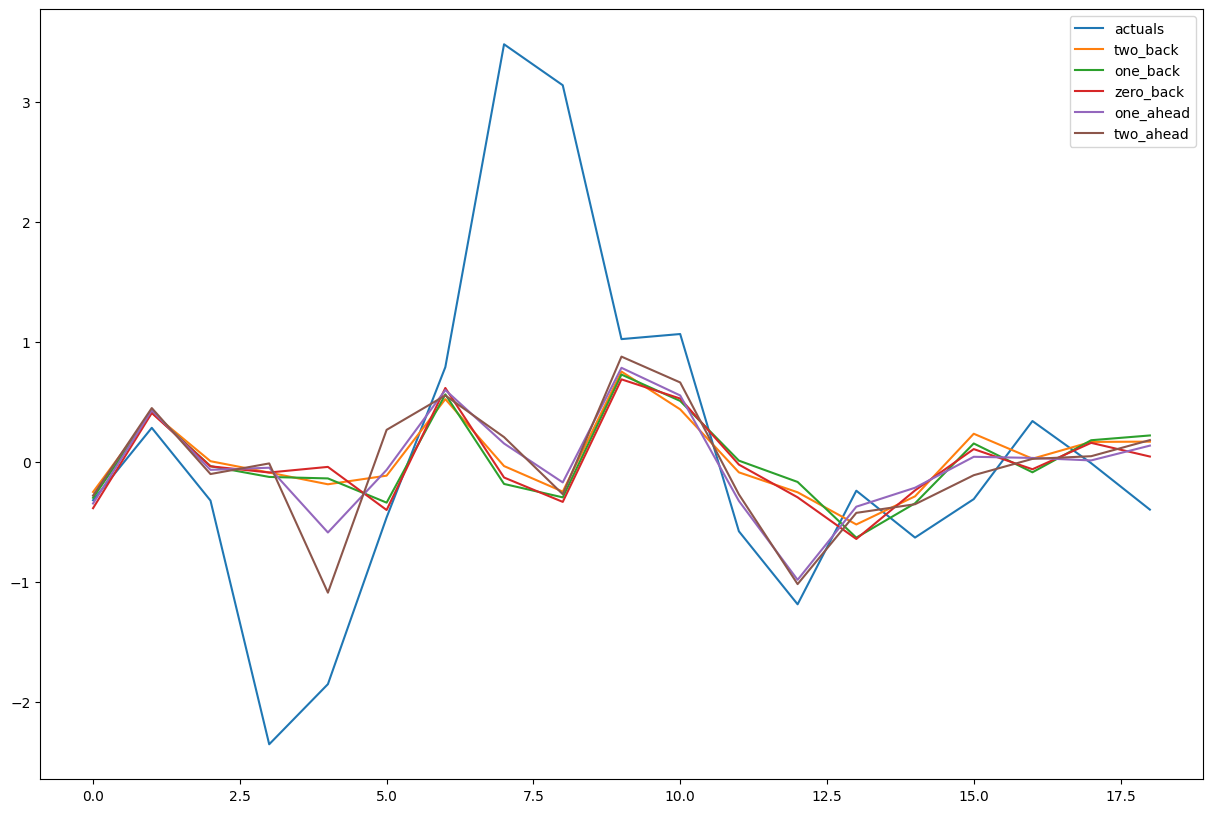

In [35]:
evaluate_ridge(data = data, target_variable='egpiv', model_params=egpiv_opt_new, plot=1, save=1)

In [36]:
target_variable = 'construction'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
construction_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-28 16:12:29,243] A new study created in memory with name: no-name-c7fb1c26-5df5-43bd-907e-faae8c0c3fc4
[I 2024-04-28 16:12:33,772] Trial 0 finished with value: 5.06960920122426 and parameters: {'pval': 0.10198082161800735, 'alpha': 0.06862117483001905, 'flat': 6}. Best is trial 0 with value: 5.06960920122426.
[I 2024-04-28 16:12:35,805] Trial 1 finished with value: 3.3701348694355535 and parameters: {'pval': 0.0001978092777963735, 'alpha': 0.49693187197061234, 'flat': 4}. Best is trial 1 with value: 3.3701348694355535.
[I 2024-04-28 16:12:37,296] Trial 2 finished with value: 3.3701493916834657 and parameters: {'pval': 0.0006553821926889259, 'alpha': 2.0939713360460344, 'flat': 3}. Best is trial 1 with value: 3.3701348694355535.
[I 2024-04-28 16:12:38,799] Trial 3 finished with value: 3.3640709629826353 and parameters: {'pval': 0.0037372916976338775, 'alpha': 0.001955537450543452, 'flat': 2}. Best is trial 3 with value: 3.3640709629826353.
[I 2024-04-28 16:12:41,664] Trial 4 

Best MAE=2.7952043531407944, best parameters:{'pval': 0.015092221533279838, 'alpha': 293.4116776509391, 'flat': 7}


  Vintage    RMSE     MAE
0      -2  4.2444  3.3815
1      -1  4.0128  3.1534
2       0  4.0767  3.1801
3       1  3.9119  3.1029
4       2  3.5897  2.7952


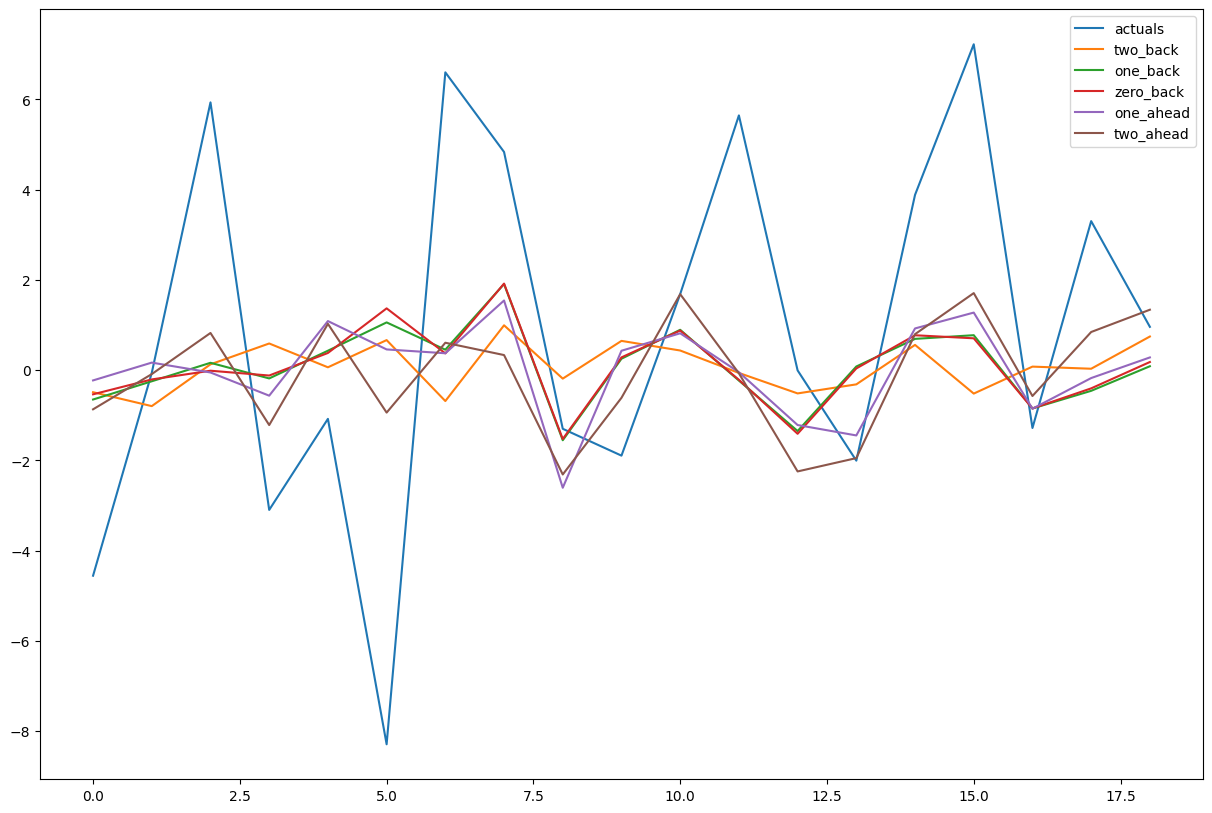

In [37]:
evaluate_ridge(data = data, target_variable='construction', model_params=construction_opt_new, plot=1, save=1)

In [58]:
target_variable = 'trade'
study = optuna.create_study()
study.optimize(objective, n_trials = 1000)
trade_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-30 01:00:00,888] A new study created in memory with name: no-name-6a3d21c3-314f-402e-ad0f-faf7b4ac03d0
[I 2024-04-30 01:00:04,132] Trial 0 finished with value: 4.699136009887809 and parameters: {'pval': 0.027807873288309123, 'alpha': 0.3469152262042934, 'flat': 2}. Best is trial 0 with value: 4.699136009887809.
[I 2024-04-30 01:00:15,971] Trial 1 finished with value: 4.079890141551359 and parameters: {'pval': 0.14907176308654976, 'alpha': 16539.12400480722, 'flat': 2}. Best is trial 1 with value: 4.079890141551359.
[I 2024-04-30 01:00:22,740] Trial 2 finished with value: 5.425573417348633 and parameters: {'pval': 0.003370957176864145, 'alpha': 4.99533516921424, 'flat': 6}. Best is trial 1 with value: 4.079890141551359.
[I 2024-04-30 01:00:30,480] Trial 3 finished with value: 4.13295229840944 and parameters: {'pval': 0.15489747316453956, 'alpha': 442.4419016242202, 'flat': 5}. Best is trial 1 with value: 4.079890141551359.
[I 2024-04-30 01:00:38,186] Trial 4 finished with val

Best MAE=2.7280399678023755, best parameters:{'pval': 0.04963827423234162, 'alpha': 78.21410676619787, 'flat': 3}


  Vintage    RMSE     MAE
0      -2  6.9022  4.5972
1      -1  6.8144  4.5295
2       0  6.0842  4.3003
3       1  4.0483  3.5275
4       2  3.5766  3.0056


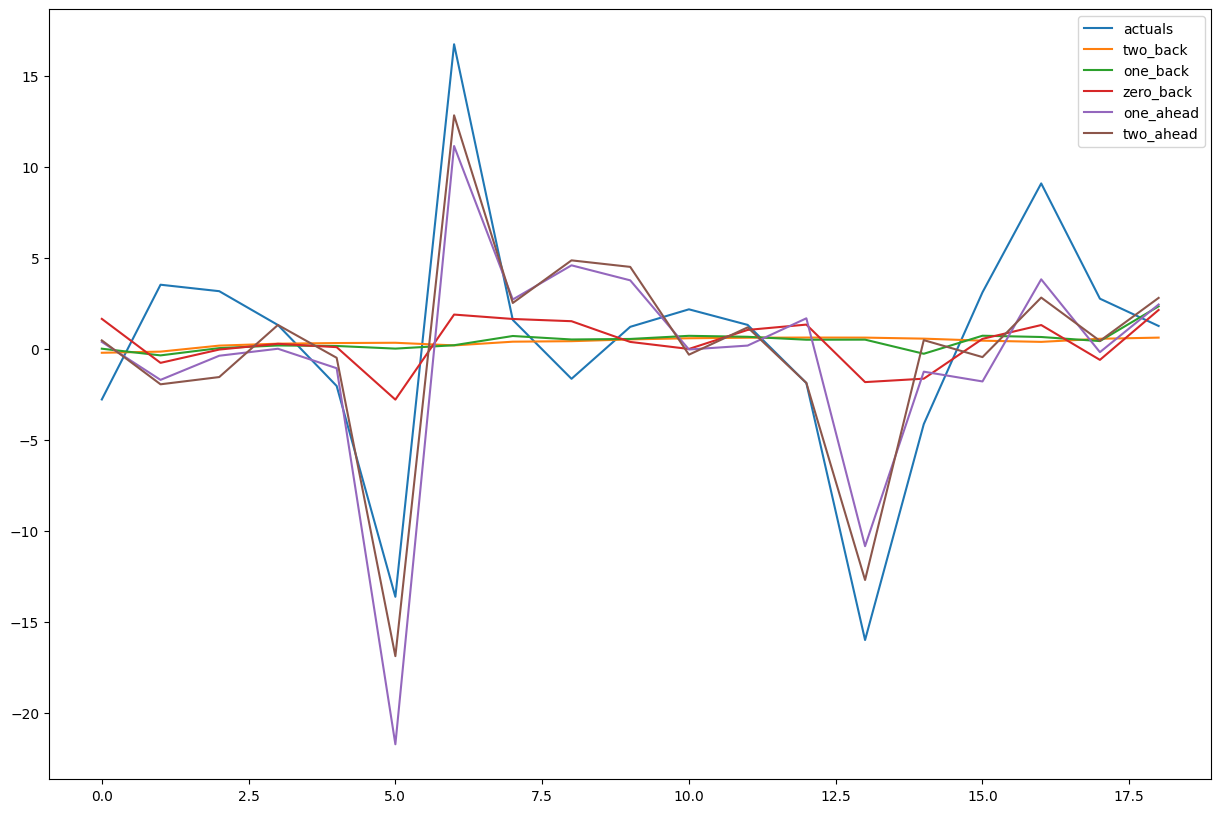

In [39]:
evaluate_ridge(data = data, target_variable='trade', model_params=trade_opt_new, plot=1, save=1)

In [56]:
target_variable = 'transport'
study = optuna.create_study()
study.optimize(objective, n_trials = 1000)
transport_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-29 21:16:38,757] A new study created in memory with name: no-name-37d30143-89e8-4e85-807a-400eea31eaa5
[I 2024-04-29 21:16:42,580] Trial 0 finished with value: 3.453869698189674 and parameters: {'pval': 0.0006283917799957724, 'alpha': 0.03598925166803956, 'flat': 6}. Best is trial 0 with value: 3.453869698189674.
[I 2024-04-29 21:16:49,960] Trial 1 finished with value: 3.2096413271406763 and parameters: {'pval': 0.30962053519105703, 'alpha': 0.1166215445585702, 'flat': 7}. Best is trial 1 with value: 3.2096413271406763.
[I 2024-04-29 21:17:02,053] Trial 2 finished with value: 3.1777786604422396 and parameters: {'pval': 0.6225398172342954, 'alpha': 13.261462028789374, 'flat': 5}. Best is trial 2 with value: 3.1777786604422396.
[I 2024-04-29 21:17:05,566] Trial 3 finished with value: 7.1556469272028576 and parameters: {'pval': 0.006883130000349891, 'alpha': 0.003431597590148333, 'flat': 5}. Best is trial 2 with value: 3.1777786604422396.
[I 2024-04-29 21:17:19,261] Trial 4 fin

Best MAE=2.1245986503854204, best parameters:{'pval': 0.000143235997010105, 'alpha': 4.840131662907905, 'flat': 2}


  Vintage    RMSE     MAE
0      -2  4.7510  2.6041
1      -1  4.7510  2.6041
2       0  4.7510  2.6041
3       1  3.8271  2.0551
4       2  3.9218  2.1246


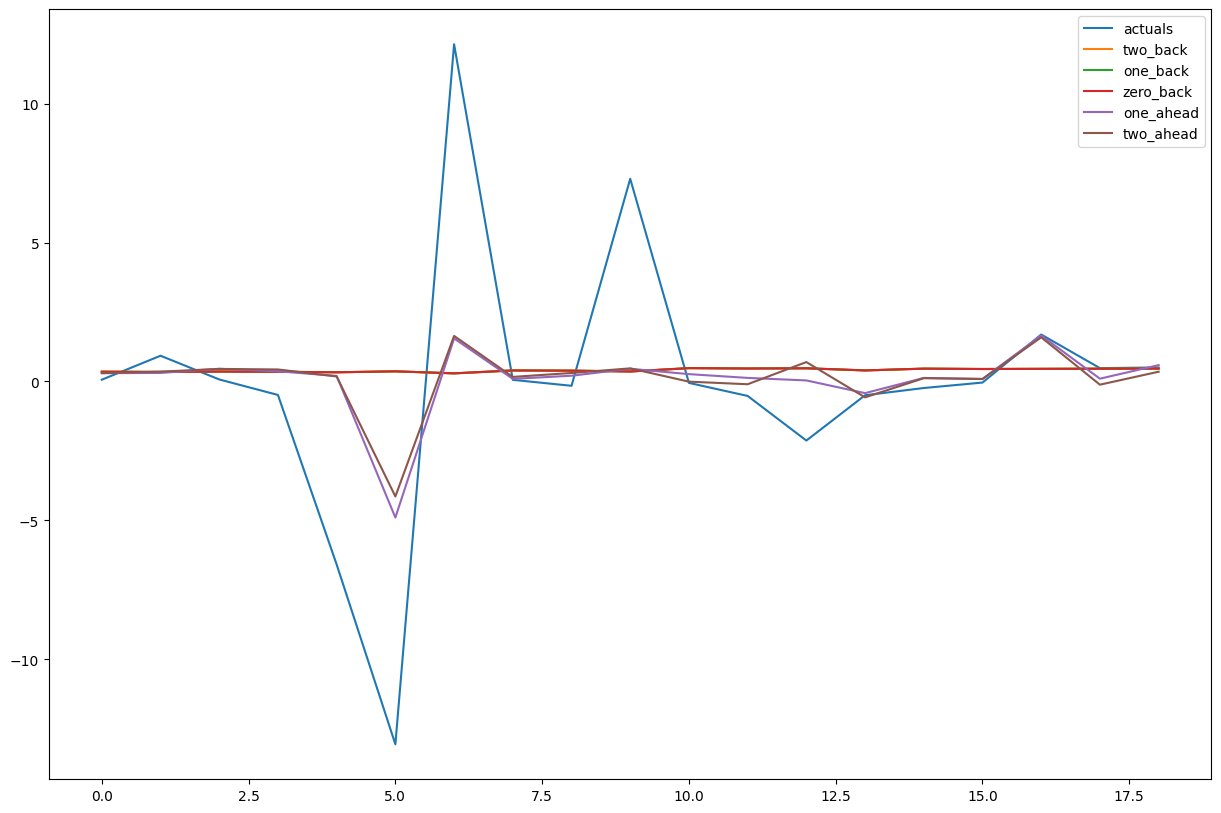

In [57]:
evaluate_ridge(data = data, target_variable='transport', model_params=transport_opt_new, plot=1, save=1)

In [54]:
target_variable = 'finance'
study = optuna.create_study()
study.optimize(objective, n_trials = 1000)
finance_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-29 15:15:06,375] A new study created in memory with name: no-name-a568a72c-ed7e-43ed-940f-e20c281099cc


[I 2024-04-29 15:15:10,346] Trial 0 finished with value: 2.0896228773506236 and parameters: {'pval': 0.08928219265555903, 'alpha': 2083.46505737854, 'flat': 4}. Best is trial 0 with value: 2.0896228773506236.
[I 2024-04-29 15:15:10,382] Trial 1 finished with value: 1000.0 and parameters: {'pval': 0.00025122231729242443, 'alpha': 0.005023166286688624, 'flat': 5}. Best is trial 0 with value: 2.0896228773506236.
[I 2024-04-29 15:15:10,412] Trial 2 finished with value: 1000.0 and parameters: {'pval': 0.0007724648724715263, 'alpha': 0.2443784918222921, 'flat': 4}. Best is trial 0 with value: 2.0896228773506236.
[I 2024-04-29 15:15:12,869] Trial 3 finished with value: 3.7662718391513907 and parameters: {'pval': 0.016717968485239428, 'alpha': 1.20156973687557, 'flat': 2}. Best is trial 0 with value: 2.0896228773506236.
[I 2024-04-29 15:15:15,948] Trial 4 finished with value: 22.808324402946376 and parameters: {'pval': 0.011421444011971088, 'alpha': 0.00199300404685245, 'flat': 6}. Best is tri

Best MAE=1.6696264026627088, best parameters:{'pval': 0.0012617634890843496, 'alpha': 9.757185333824392, 'flat': 3}


  Vintage    RMSE     MAE
0      -2  2.2716  1.7915
1      -1  2.2716  1.7915
2       0  2.5731  2.0666
3       1  2.1100  1.6831
4       2  2.0773  1.6696


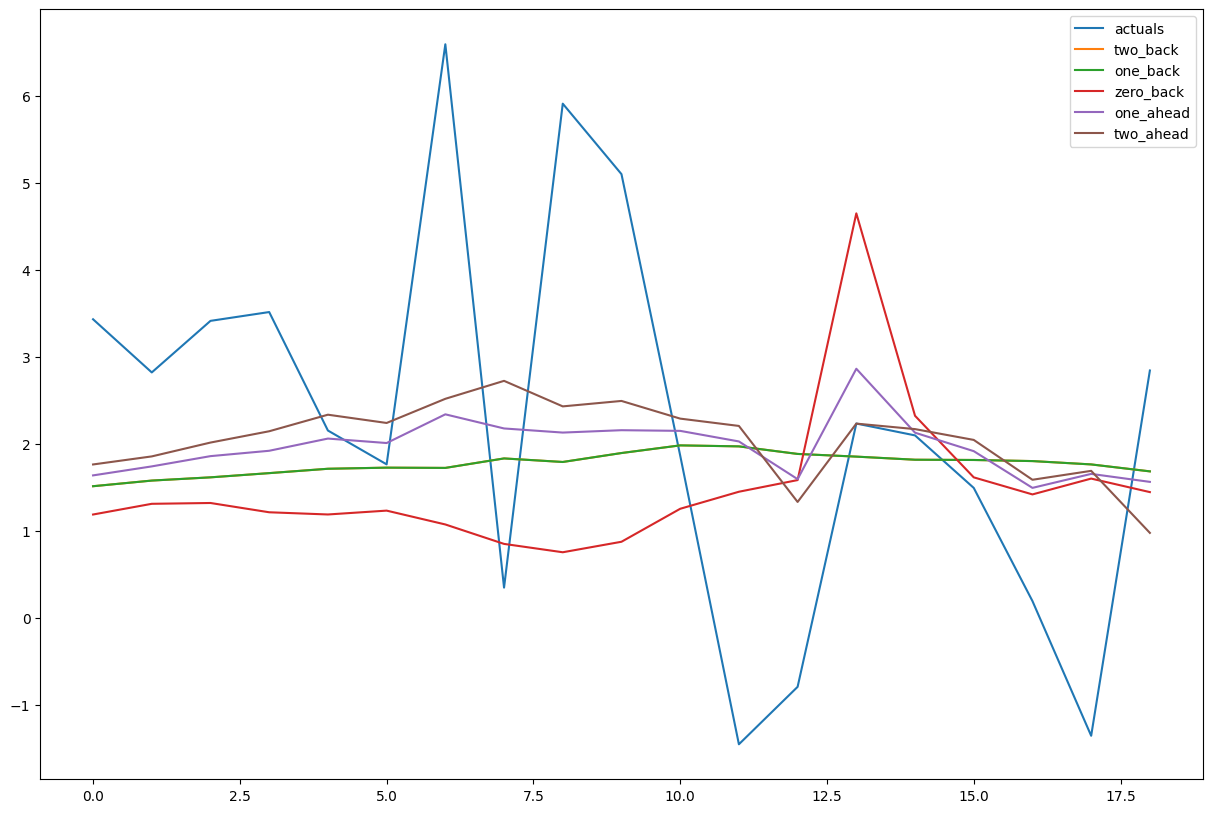

In [55]:
evaluate_ridge(data = data, target_variable='finance', model_params=finance_opt_new, plot=1, save=1)

In [43]:
target_variable = 'real_estate'
study = optuna.create_study()
study.optimize(objective, n_trials = 300)
real_estate_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-28 18:25:14,079] A new study created in memory with name: no-name-5a3fddad-93bc-49cb-b0a2-7e0b3877a378
[I 2024-04-28 18:25:17,168] Trial 0 finished with value: 1.133747686075911 and parameters: {'pval': 0.0008641599072816401, 'alpha': 13.364974163789118, 'flat': 7}. Best is trial 0 with value: 1.133747686075911.
[I 2024-04-28 18:25:20,324] Trial 1 finished with value: 1.909609445460678 and parameters: {'pval': 0.046142017339266816, 'alpha': 0.20185904369296603, 'flat': 3}. Best is trial 0 with value: 1.133747686075911.
[I 2024-04-28 18:25:23,715] Trial 2 finished with value: 1.16937793656535 and parameters: {'pval': 0.07073876585633934, 'alpha': 65.49891481103204, 'flat': 2}. Best is trial 0 with value: 1.133747686075911.
[I 2024-04-28 18:25:23,743] Trial 3 finished with value: 1000.0 and parameters: {'pval': 4.423380571880069e-05, 'alpha': 8761.689227318138, 'flat': 6}. Best is trial 0 with value: 1.133747686075911.
[I 2024-04-28 18:25:26,731] Trial 4 finished with value: 0

Best MAE=0.8431667216869067, best parameters:{'pval': 0.5767805814888594, 'alpha': 112.92000474064342, 'flat': 3}


  Vintage    RMSE     MAE
0      -2  1.3725  1.0148
1      -1  1.5270  1.0849
2       0  1.5154  1.1027
3       1  1.4047  1.0561
4       2  1.1253  0.8432


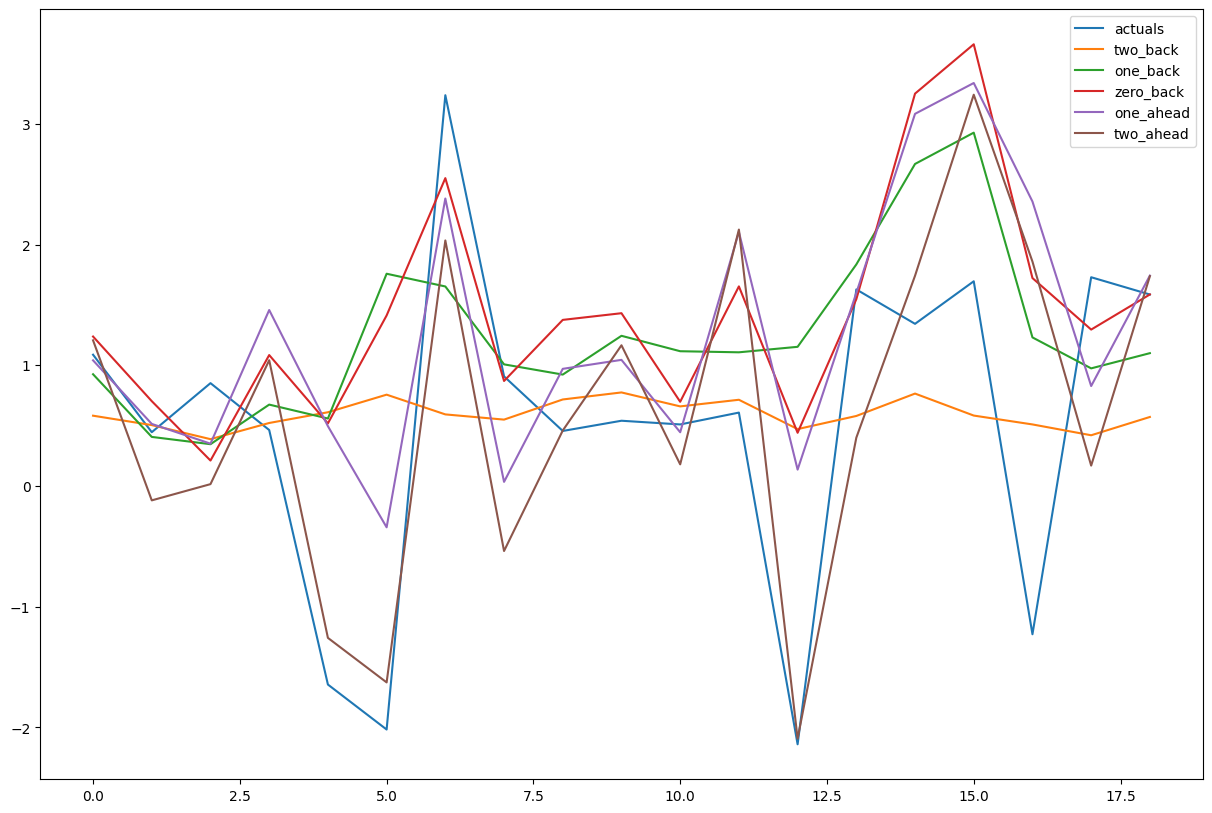

In [44]:
evaluate_ridge(data = data, target_variable='real_estate', model_params=real_estate_opt_new, plot=1, save=1)

In [50]:
target_variable = 'others'
study = optuna.create_study()
study.optimize(objective, n_trials = 1000)
others_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-28 22:48:30,452] A new study created in memory with name: no-name-d6b9ea01-d0c3-44e2-a060-2ddb52920518
[I 2024-04-28 22:48:35,186] Trial 0 finished with value: 3.078232914108743 and parameters: {'pval': 0.09169508348551922, 'alpha': 23709.003815104155, 'flat': 5}. Best is trial 0 with value: 3.078232914108743.
[I 2024-04-28 22:48:36,958] Trial 1 finished with value: 3.486304455846819 and parameters: {'pval': 0.00045233014259620603, 'alpha': 246.3368868404945, 'flat': 3}. Best is trial 0 with value: 3.078232914108743.
[I 2024-04-28 22:48:47,776] Trial 2 finished with value: 3.1538408373485356 and parameters: {'pval': 0.8409018130055635, 'alpha': 159.678472017122, 'flat': 3}. Best is trial 0 with value: 3.078232914108743.
[I 2024-04-28 22:48:49,771] Trial 3 finished with value: 3.5640351892469235 and parameters: {'pval': 6.287276584265332e-05, 'alpha': 0.19461369482448196, 'flat': 4}. Best is trial 0 with value: 3.078232914108743.
[I 2024-04-28 22:48:51,520] Trial 4 finished w

Best MAE=1.953462415642153, best parameters:{'pval': 0.00470096044214615, 'alpha': 67.52217982521127, 'flat': 5}


  Vintage    RMSE     MAE
0      -2  4.0496  3.1907
1      -1  3.5017  2.4718
2       0  3.9170  2.7607
3       1  3.1271  2.3725
4       2  2.5234  1.9535


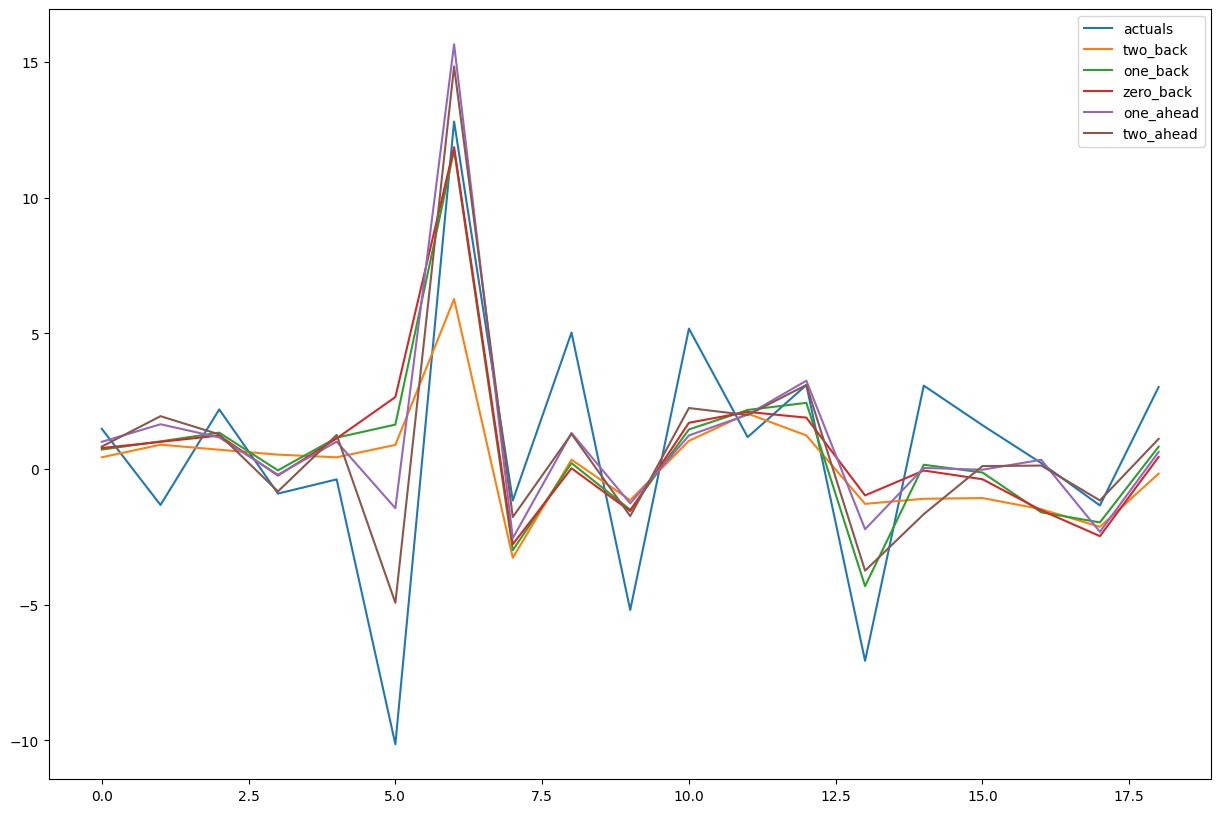

In [51]:
evaluate_ridge(data = data, target_variable='others', model_params=others_opt_new, plot=1, save=1)

In [52]:
target_variable = 'taxes'
study = optuna.create_study()
study.optimize(objective, n_trials = 1000)
taxes_opt_new = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-29 00:01:51,691] A new study created in memory with name: no-name-3c39df4b-1d52-4f76-9082-979792b85fea


[I 2024-04-29 00:01:55,772] Trial 0 finished with value: 2.638305551618262 and parameters: {'pval': 0.0005403472402937437, 'alpha': 72332.6443189281, 'flat': 7}. Best is trial 0 with value: 2.638305551618262.
[I 2024-04-29 00:01:57,593] Trial 1 finished with value: 2.946457158968846 and parameters: {'pval': 8.06745770125148e-05, 'alpha': 1.5305140082182567, 'flat': 3}. Best is trial 0 with value: 2.638305551618262.
[I 2024-04-29 00:01:59,660] Trial 2 finished with value: 2.2428580234703315 and parameters: {'pval': 0.002344532082934671, 'alpha': 1489.4132694946595, 'flat': 3}. Best is trial 2 with value: 2.2428580234703315.
[I 2024-04-29 00:02:03,117] Trial 3 finished with value: 2.83970180979461 and parameters: {'pval': 0.009929306197904513, 'alpha': 4.639744911251081, 'flat': 6}. Best is trial 2 with value: 2.2428580234703315.
[I 2024-04-29 00:02:06,798] Trial 4 finished with value: 2.9574783622371177 and parameters: {'pval': 0.019201298958826208, 'alpha': 0.004837590060680996, 'flat'

Best MAE=1.6675382128394451, best parameters:{'pval': 0.028866843167203955, 'alpha': 11.872284519519832, 'flat': 2}


  Vintage    RMSE     MAE
0      -2  4.1414  2.5508
1      -1  3.0836  2.0119
2       0  3.1349  2.1951
3       1  2.6422  1.6985
4       2  2.6663  1.6675


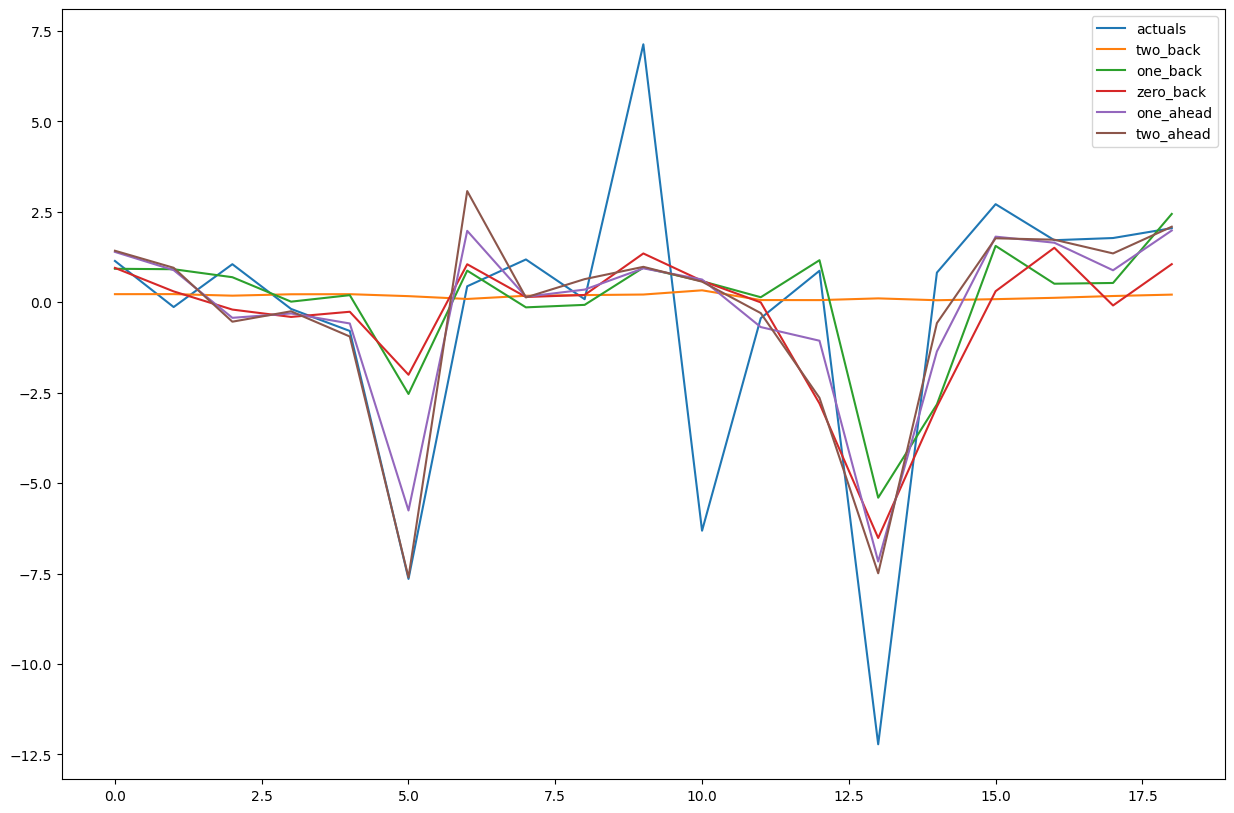

In [53]:
evaluate_ridge(data = data, target_variable='taxes', model_params=taxes_opt_new, plot=1, save=1)